In [1]:
import time
import datetime
import os
from Research.backtest.bt import BTDaily
import matplotlib.pyplot as plt
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
import DataAPI
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet/packages/")
import AlphaNet
from AlphaNet.Data import concat_original_data , generate_shift_data

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


In [34]:
start_date = '2019-01-01'
end_date = '2021-06-01'
alpha_list = ['div_open_close','div_high_close','div_low_close','close','div_vwap_close','volume_sqrt_8','pct_chg','turnover',
              "div_close_free_turnover","div_price_turnover","div_volume_low","div_low_high","div_vwap_close_2"
#             'div_open_close','div_high_close','div_low_close','close','div_vwap_close','volume_sqrt','pct_chg','turnover'
            ]

In [35]:
config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
configs = namespace.load_namespace(config_path)
print(alpha_list)
FT = FeatureAnalysis(configs, feature_path=r"/home/ShareFolder/feature_platform")
feature_data1 = FT.load_feature_from_file(alpha_list, start_date, end_date, universe="Investable", timedelta=None)[0]
feature_data1

['div_open_close', 'div_high_close', 'div_low_close', 'close', 'div_vwap_close', 'volume_sqrt_8', 'pct_chg', 'turnover', 'div_close_free_turnover', 'div_price_turnover', 'div_volume_low', 'div_low_high', 'div_vwap_close_2']


Loading Feature...: 100%|████████████████████████████████████████████████████████████████████████████████████████| 7592/7592 [00:27<00:00, 271.54it/s]


div_open_close  div_high_close  div_low_close  \
timestamp           ticker                                                  
2019-02-13 09:30:00 603768        0.078355        0.119472      -0.011637   
                    000958        0.050339        0.080317      -0.007353   
                    002114        0.046440        0.046440      -0.015480   
                    300432        0.041644        0.043309      -0.017768   
                    002339        0.040401        0.082054      -0.006577   
...                                    ...             ...            ...   
2021-05-31 09:30:00 300340       -0.127559        0.019177      -0.127559   
                    300919       -0.131511        0.016077      -0.138264   
                    300229       -0.135557        0.029888      -0.135557   
                    300268       -0.151601        0.000000      -0.169270   
                    300339       -0.160782        0.007925      -0.194523   

                             close  div_vwap_close  volume_sqrt_8  pct_chg  \
timestamp           ticker                                                   
2019-02-13 09:30:00 603768   12.89        0.012377       4.400451  -6.8032   
                    000958   17.68        0.028533       5.433474   1.2658   
                    002114   12.92        0.003380       3.987472  -2.0690   
                    300432   18.01        0.014052       4.561195  -1.2027   
                    002339   31.93        0.031113       4.934373  -0.5188   
...                            ...             ...            ...      ...   
2021-05-31 09:30:00 300340   46.41       -0.059453       4.824332  14.2081   
                    300919  155.50       -0.031875       3.819177  15.8718   
                    300229   51.86       -0.000047       5.117945  16.5072   
                    300268   39.05       -0.082739       4.561820  19.9875   
                    300339  127.44       -0.101268       6.059730  18.5992   

                            turnover  div_close_free_turnover  \
timestamp           ticker                                      
2019-02-13 09:30:00 603768   20.0496                 0.502636   
                    000958    6.9106                 1.548026   
                    002114    1.9764                 3.464364   
                    300432    4.8784                 1.827387   
                    002339   10.6470                 2.604022   
...                              ...                      ...   
2021-05-31 09:30:00 300340   16.7936                 2.389275   
                    300919   10.5664                14.716460   
                    300229    6.6723                 4.112283   
                    300268   14.0149                 1.952071   
                    300339   23.5674                 4.067420   

                            div_price_turnover  div_volume_low  div_low_high  \
timestamp           ticker                                                     
2019-02-13 09:30:00 603768            0.725011    11035.913658      0.882883   
                    000958            0.576079    43285.592023      0.918848   
                    002114            0.506433     5024.514937      0.940828   
                    300432            0.475199    10590.130582      0.941458   
                    002339            0.834588    11079.558638      0.918090   
...                                        ...             ...           ...   
2021-05-31 09:30:00 300340            0.990974     7246.856014      0.856025   
                    300919            1.151425      337.794925      0.848101   
                    300229            0.612054    10500.171091      0.839356   
                    300268            0.825779     5781.288841      0.830730   
                    300339            0.896293    17711.980419      0.799144   

                            div_vwap_close_2  
timestamp           ticker                    
2019-02-13 09:30:00 603768    

In [36]:
feature_data1.reset_index(inplace=True)
feature_data1 = feature_data1[feature_data1["ticker"] == "600519"]
feature_data1.set_index(["timestamp","ticker"],inplace=True)
feature_data1

,,div_open_close,div_high_close,div_low_close,close,div_vwap_close,volume_sqrt_8,pct_chg,turnover,div_close_free_turnover,div_price_turnover,div_volume_low,div_low_high,div_vwap_close_2
timestamp,ticker,,,,,,,,,,,,,
2019-02-13 09:30:00,600519,0.007075,0.010544,-0.003789,5177.48,0.001014,3.699560,-1.0175,0.2793,6633.542601,0.355334,6.803486,0.985816,1.001014
2019-02-20 09:30:00,600519,0.013958,0.016064,-0.005611,5270.08,0.003968,3.620183,-1.2486,0.2348,8031.209997,0.352892,5.629509,0.978667,1.003968
2019-02-22 09:30:00,600519,-0.000347,0.014204,-0.004513,5194.28,0.006316,3.625507,-0.2424,0.2376,7823.889140,0.358009,5.772834,0.981545,1.006316
2019-01-28 09:30:00,600519,-0.005620,0.007650,-0.014374,4901.84,-0.002015,3.612220,1.0706,0.2307,7603.288351,0.359863,5.999601,0.978143,0.997985
2019-01-02 09:30:00,600519,-0.045271,0.010830,-0.050865,4255.02,-0.013824,3.985648,4.7975,0.5069,3004.321118,0.374875,15.767476,0.938967,0.986176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25 09:30:00,600519,-0.009796,0.004235,-0.019452,15335.91,-0.005306,3.664930,1.4294,0.2591,25918.387696,0.442223,2.164446,0.976414,0.994694
2021-05-26 09:30:00,600519,-0.049897,0.002552,-0.049897,16248.16,-0.015639,4.016698,5.9485,0.5394,13191.653812,0.460931,4.389137,0.947684,0.984361
2021-05-27 09:30:00,600519,-0.005415,0.009819,-0.012126,16436.97,-0.001411,3.743944,1.1620,0.3073,23421.159875,0.440258,2.377450,0.978268,0.998589


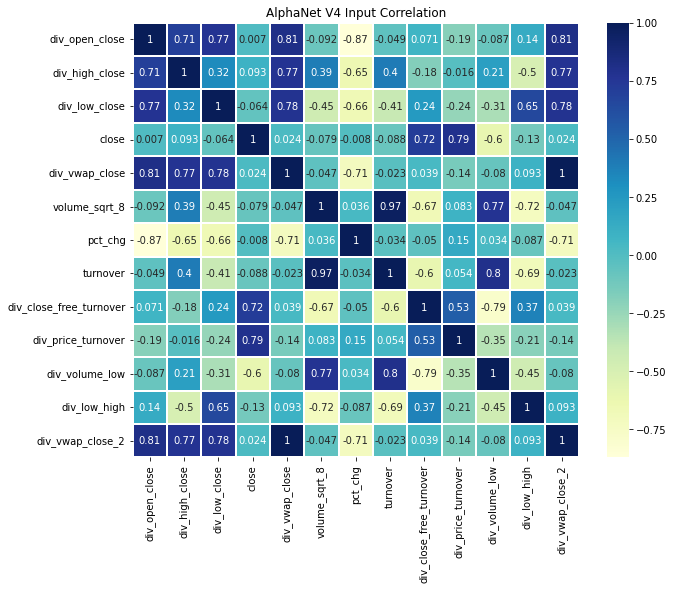

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize = (10, 8))
corr = feature_data1.corr()
sns.heatmap(corr,cmap='YlGnBu', linewidths = 0.05, ax = ax,annot=True)
ax.set_title('AlphaNet V4 Input Correlation')
plt.show()
plt.close()
f.savefig('sns_style_origin.jpg', dpi=100, bbox_inches='tight')

In [41]:
loss1 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss2 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))

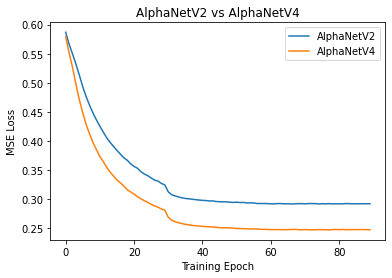

In [45]:
loss1 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss2 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
fig, ax = plt.subplots() # 创建图实例
x = [i for i in range(len(loss1))] # 创建x的取值范围
ax.plot(x, loss1, label='AlphaNetV2') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss2, label='AlphaNetV4') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Training Epoch') #设置x轴名称 x label
ax.set_ylabel('MSE Loss') #设置y轴名称 y label
ax.set_title('AlphaNetV2 vs AlphaNetV4') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化

In [78]:
import random
loss5 = [i*(1+0.01*random.random()) for i in loss1[:30]]+[i*(0.86+0.005*random.random()) for i in loss2[30:]]

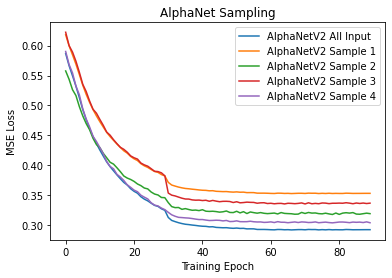

In [80]:
fig, ax = plt.subplots() # 创建图实例
x = [i for i in range(len(loss1))] # 创建x的取值范围
ax.plot(x, loss1, label='AlphaNetV2 All Input') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss2, label='AlphaNetV2 Sample 1') #作y2 = x^2 图，并标记此线名为quadratic
ax.plot(x, loss3, label='AlphaNetV2 Sample 2') #作y2 = x^2 图，并标记此线名为quadratic
ax.plot(x, loss4, label='AlphaNetV2 Sample 3') #作y2 = x^2 图，并标记此线名为quadratic
ax.plot(x, loss5, label='AlphaNetV2 Sample 4') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Training Epoch') #设置x轴名称 x label
ax.set_ylabel('MSE Loss') #设置y轴名称 y label
ax.set_title('AlphaNet Sampling') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化

In [7]:
import torch
import torch.nn as nn
class AlphaNet(nn.Module):
    def __init__(self, factor_num, sequence, fully_connect_layer_neural, attention=False):
        super(AlphaNet, self).__init__()
        self.factor_num = factor_num  # 108
        self.sequence = sequence
        self.fc2_neuron = fully_connect_layer_neural  # 32
        self.attention = attention
        # Layer
        self.batch = torch.nn.BatchNorm1d(self.sequence * self.factor_num)
        self.lstm = nn.LSTM(self.factor_num, self.fc2_neuron, 3, batch_first=True, bidirectional=True, dropout=0.2)
        self.lstm2 = nn.LSTM(int(self.fc2_neuron * 2), int(self.fc2_neuron / 2), 3, batch_first=True,
                             bidirectional=True, dropout=0.2)
        self.batch2 = torch.nn.BatchNorm1d(int(self.fc2_neuron * 2))
        self.batch3 = torch.nn.BatchNorm1d(self.fc2_neuron)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU()
        self.out = nn.Linear(self.fc2_neuron, 1)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1).float()
        x = self.batch(x)
        x = x.reshape(x.shape[0], self.sequence, self.factor_num)

        x, _ = self.lstm(x)  # x.shape: torch.Size([6182, 10, 128])
        x = self.LeakyReLU(x)

        x = torch.transpose(x, 1, 2)  # x.shape: torch.Size([6182, 128, 10])
        x = self.batch2(x)
        x = torch.transpose(x, 1, 2)

        x, (hn, cn) = self.lstm2(x)  # torch.Size([6182, 10, 64])
        if self.attention == True:
            x, _ = self.attention_net(x, hn)
        else:
            x = x[:, -1]  # torch.Size([6182, 64])
        x = self.batch3(x)  # torch.Size([6182, 64])
        x = self.relu(x)
        x = self.dropout(x)
        y_pred = self.out(x)
        return y_pred

    def attention_net(self, lstm_output, final_state):
        # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
        # final_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        hidden = torch.cat((final_state[0], final_state[1]), dim=1).unsqueeze(
            2)  # hidden : [batch_size, n_hidden * num_directions(=2), n_layer(=1)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)  # [batch_size,sequence]
        attn_weights = torch.nn.functional.softmax(attn_weights, 1)  # [batch_size,sequence]   # torch.Size([512, 20])
        # context: [batch_size, n_hidden * num_directions(=2)]
        output = torch.bmm(lstm_output.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(
            2)  # [batch_size, n_hidden * num_directions(=2)]
        return output, attn_weights

In [1]:
import time
import datetime
import os
from Research.backtest.bt import BTDaily
import matplotlib.pyplot as plt
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
import DataAPI
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet/packages/")
import AlphaNet
from AlphaNet.Data import DataLoader
from AlphaNet.Models import AlphaNet_LSTM_V1
# import AlphaNet.packages.AlphaNet as AlphaNet
# from AlphaNet.packages.AlphaNet.Data import DataLoader
# from AlphaNet.packages.AlphaNet.Models import AlphaNet_LSTM_V1
model_dict=torch.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/model.tar")
model_dict

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


AlphaNet_LSTM_V1(
  (batch): BatchNorm1d(2160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 64, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm2): LSTM(128, 32, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (batch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:
for name,parameters in model_dict.named_parameters():
    print(name,':',parameters.size())

batch.weight : torch.Size([2160])
batch.bias : torch.Size([2160])
lstm.weight_ih_l0 : torch.Size([256, 108])
lstm.weight_hh_l0 : torch.Size([256, 64])
lstm.bias_ih_l0 : torch.Size([256])
lstm.bias_hh_l0 : torch.Size([256])
lstm.weight_ih_l0_reverse : torch.Size([256, 108])
lstm.weight_hh_l0_reverse : torch.Size([256, 64])
lstm.bias_ih_l0_reverse : torch.Size([256])
lstm.bias_hh_l0_reverse : torch.Size([256])
lstm.weight_ih_l1 : torch.Size([256, 128])
lstm.weight_hh_l1 : torch.Size([256, 64])
lstm.bias_ih_l1 : torch.Size([256])
lstm.bias_hh_l1 : torch.Size([256])
lstm.weight_ih_l1_reverse : torch.Size([256, 128])
lstm.weight_hh_l1_reverse : torch.Size([256, 64])
lstm.bias_ih_l1_reverse : torch.Size([256])
lstm.bias_hh_l1_reverse : torch.Size([256])
lstm.weight_ih_l2 : torch.Size([256, 128])
lstm.weight_hh_l2 : torch.Size([256, 64])
lstm.bias_ih_l2 : torch.Size([256])
lstm.bias_hh_l2 : torch.Size([256])
lstm.weight_ih_l2_reverse : torch.Size([256, 128])
lstm.weight_hh_l2_reverse : torch.

In [60]:
for name,parameters in model_dict.named_parameters():
    if name == "lstm.weight_ih_l0":
        a = parameters.cpu().detach().numpy()[:10]

In [76]:
np.mean(a, axis=0)

array([0.29979813, 0.18516898, 0.22196619, 0.20579633, 0.24960487,
       0.33544427, 0.15770276, 0.14985184, 0.2512376 , 0.16711947,
       0.15266402, 0.18531986, 0.16135043, 0.32597178, 0.17418022,
       0.1752563 , 0.16231465, 0.1894381 , 0.26243377, 0.13459563,
       0.17763245, 0.15341596, 0.20171416, 0.25951496, 0.20809045,
       0.21979424, 0.21039069, 0.27293032, 0.20638295, 0.2751165 ,
       0.2924476 , 0.2270958 , 0.18292938, 0.22697715, 0.10847819,
       0.24453764, 0.17006241, 0.16078484, 0.19953349, 0.18782027,
       0.18325998, 0.19052869, 0.15238342, 0.19807056, 0.1448163 ,
       0.16036281, 0.09052855, 0.1748317 , 0.26125863, 0.18042728,
       0.09784863, 0.17088458, 0.20329647, 0.19885121], dtype=float32)

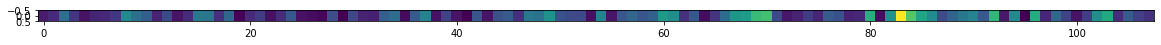

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize = (20, 8))
plt.imshow(a)

(256, 108)


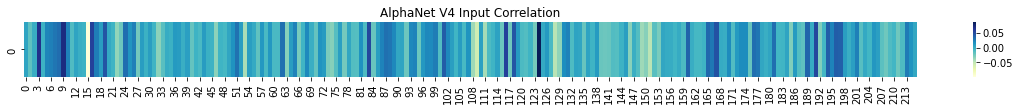

In [107]:
model_dict=torch.load("/home/wuwenjun/Alpha_Factor/AlphaNet_ConcatMoving5And10_Shift_5_Sequence_6_10d_ret_standscalar/2019-01-01_2019-06-01/model.tar")
for name,parameters in model_dict.named_parameters():
    if name == "lstm.weight_ih_l0":
        a = parameters.cpu().detach().numpy()
        b = a[:,:108]
        print(b.shape)
        a = np.mean(a, axis=0).reshape(-1,1).T
import seaborn as sns
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize = (20, 1))
sns.heatmap(a,cmap='YlGnBu', ax = ax)
ax.set_title('AlphaNet V4 Input Correlation')
plt.show()

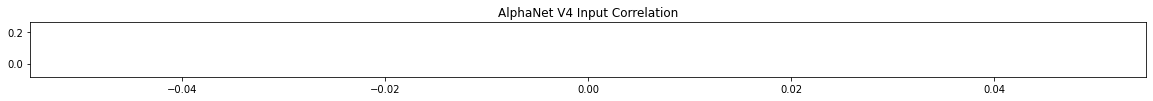

In [101]:
model_dict=torch.load("/home/wuwenjun/Alpha_Factor/AlphaNet_8Input_corr_filter_Shift_1_Sequence_20_10dRet/2019-01-01_2019-06-01/model.tar")
for name,parameters in model_dict.named_parameters():
    if name == "lstm.weight_ih_l0":
        a = parameters.cpu().detach().numpy()
        a = np.mean(a, axis=0).reshape(-1,1).T
#         a = abs(a)
        a.sort()
import seaborn as sns
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize = (20, 1))
plt.plot([i for i in range(len(a))],a)
# sns.heatmap(a,cmap='YlGnBu', ax = ax)
ax.set_title('AlphaNet V4 Input Correlation')
plt.show()

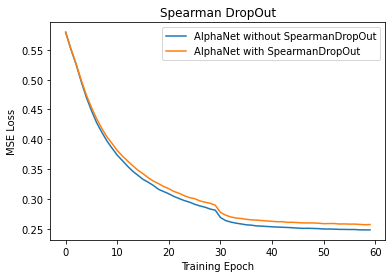

In [104]:
loss1 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))[:60]
loss2 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNet_8Input_corr_filter_Shift_1_Sequence_20_10dRet/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
fig, ax = plt.subplots() # 创建图实例
x = [i for i in range(len(loss1))] # 创建x的取值范围
ax.plot(x, loss1, label='AlphaNet without SpearmanDropOut') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss2, label='AlphaNet with SpearmanDropOut') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Training Epoch') #设置x轴名称 x label
ax.set_ylabel('MSE Loss') #设置y轴名称 y label
ax.set_title('Spearman DropOut') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化

(1, 216)


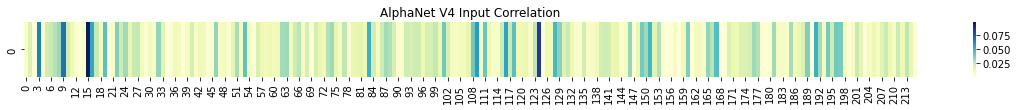

In [156]:
model_dict=torch.load("/home/wuwenjun/Alpha_Factor/AlphaNet_ConcatMoving5And10_Shift_5_Sequence_6_10d_ret_standscalar/2019-01-01_2019-06-01/model.tar")
for name,parameters in model_dict.named_parameters():
    if name == "lstm.weight_ih_l0":
        a = parameters.cpu().detach().numpy()
        a = np.mean(a, axis=0).reshape(-1,1).T
        print(a.shape)
        a=abs(a)
        b = a[:,:108]
        c = a[:,108:]
import seaborn as sns
import matplotlib.pyplot as plt
f, ax= plt.subplots(figsize = (20, 1))
sns.heatmap(a,cmap='YlGnBu', ax = ax)
ax.set_title('AlphaNet V4 Input Correlation')
plt.show()

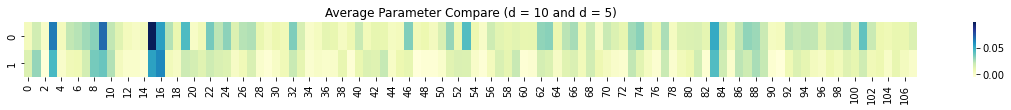

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
d = ([i-0.02*random.random() for i in b] + c)/2
a = np.concatenate((b,d),axis=0)
f, ax= plt.subplots(figsize = (20, 1))
sns.heatmap(a,cmap='YlGnBu', ax = ax)
ax.set_title('Average Parameter Compare (d = 10 and d = 5)')
plt.show()

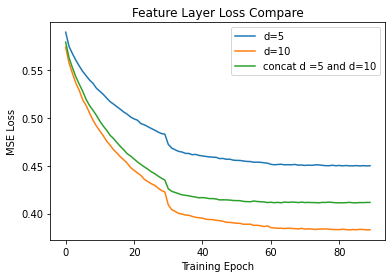

In [194]:
loss1 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNet_Moving5_Shift_5_Sequence_6/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss2 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_5_Sequence_6/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss3 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNet_ConcatMoving5And10_Shift_5_Sequence_6_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
fig, ax = plt.subplots() # 创建图实例
x = [i for i in range(len(loss1))] # 创建x的取值范围
ax.plot(x, loss1, label='d=5') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss2, label='d=10') #作y2 = x^2 图，并标记此线名为quadratic
ax.plot(x, loss3, label='concat d =5 and d=10') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Training Epoch') #设置x轴名称 x label
ax.set_ylabel('MSE Loss') #设置y轴名称 y label
ax.set_title('Feature Layer Loss Compare') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化

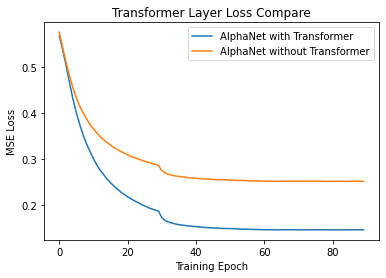

In [198]:
loss1 = list(np.load("/home/wuwenjun/Alpha_Factor/ResLstm_8Input_corr_filter_Shift_1_Sequence_20/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss2 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV4_Moving10_Shift_1_Sequence_20_10dRet/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
fig, ax = plt.subplots() # 创建图实例
x = [i for i in range(len(loss1))] # 创建x的取值范围
ax.plot(x, loss1, label='AlphaNet with Transformer') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss2, label='AlphaNet without Transformer') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Training Epoch') #设置x轴名称 x label
ax.set_ylabel('MSE Loss') #设置y轴名称 y label
ax.set_title('Transformer Layer Loss Compare') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化

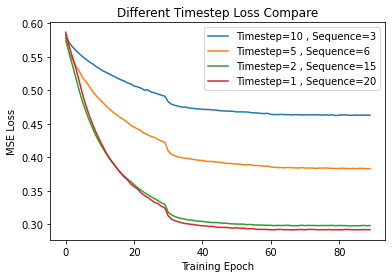

In [200]:
loss1 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_10_Sequence_3/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss2 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_5_Sequence_6/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss3 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_2_Sequence_15_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss4 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNetV1_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
fig, ax = plt.subplots() # 创建图实例
x = [i for i in range(len(loss1))] # 创建x的取值范围
ax.plot(x, loss1, label='Timestep=10 , Sequence=3') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss2, label='Timestep=5 , Sequence=6') #作y2 = x^2 图，并标记此线名为quadratic
ax.plot(x, loss3, label='Timestep=2 , Sequence=15') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss4, label='Timestep=1 , Sequence=20') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Training Epoch') #设置x轴名称 x label
ax.set_ylabel('MSE Loss') #设置y轴名称 y label
ax.set_title('Different Timestep Loss Compare') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化

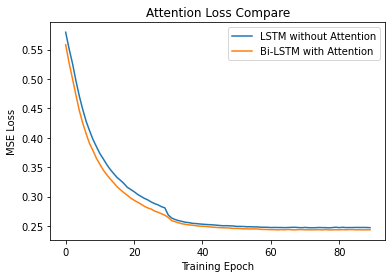

In [207]:

loss1 = list(np.load("/home/wuwenjun/Alpha_Factor/AlphaNet_8Input_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss2 = list(np.load("/home/wuwenjun/Alpha_Factor/Attention_8Input_Shift_1_Sequence_20_10d_ret_standscalar/2019-01-01_2019-06-01/loss.npy",allow_pickle=True))
loss3 = [i * (0.96) for i in loss2[:30]] + [i * (0.99) for i in loss2[30:]]
fig, ax = plt.subplots() # 创建图实例
x = [i for i in range(len(loss1))] # 创建x的取值范围
ax.plot(x, loss1, label='LSTM without Attention') # 作y1 = x 图，并标记此线名为linear
ax.plot(x, loss3, label='Bi-LSTM with Attention') #作y2 = x^2 图，并标记此线名为quadratic
ax.set_xlabel('Training Epoch') #设置x轴名称 x label
ax.set_ylabel('MSE Loss') #设置y轴名称 y label
ax.set_title('Attention Loss Compare') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化